In [ ]:
pip install powerlaw

In [ ]:
 #networkx para teoría de grafos, matplot para gráficar y random para generar números aleatorios
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp 
from scipy import stats as st
import math 
from scipy.optimize import fsolve
import powerlaw

#las siguientes 4 funciones remueven N nodos o enlaces de forma aleatoria y dirigida de un grafo dado como input

In [ ]:
#remueve nodos con mayor load
def remove_hubs_load(G,nodos_removidos): 
  """
  (G, #nodos_removidos) ---------> G
  """
  for i in range(nodos_removidos):
    keys = list(nx.load_centrality(G).keys())
    values = list(nx.load_centrality(G).values())
    maxval = max(values)
    casilla_nodo = values.index(maxval)
    G.remove_node(keys[casilla_nodo])
  return G


#remueve edges con mayor load
def edge_remove_hub_load(G,edges_removidos): 
  """
  (G,#edges_removidos) -------> G
  """
  for i in range(edges_removidos):
    keys = list(nx.edge_load_centrality(G).keys())
    values = list(nx.load_centrality(G).values())
    maxval = max(values)
    casilla_edge = values.index(maxval)
    G.remove_edge(keys[casilla_edge][0],keys[casilla_edge][1])
  return G

#remueve nodos aleatoriamente
def remove_aleatory(G,nodos_removidos): 
  """
  (G,#nodos_removidos) -----------> G
  """
  keys = list(G.nodes())
  for i in range(nodos_removidos):
    remove_node = np.random.randint(0,G.number_of_nodes())
    remnode = keys[remove_node]
    if (remnode in G) == True:
      G.remove_node(remnode)
  return G

#remueve edges aleatoriamente
def edge_remove_aleatory(G,edges_removidos): 
  """
  (G,#edges_removidos) ------> G
  """
  for i in range(edges_removidos):
    remove_edge = np.random.randint(0,len(nx.edges(G)))
    if (remove_edge in G) ==True:
      G.remove_edge(list(nx.edges(G))[remove_edge][0],list(nx.edges(G))[remove_edge][1])
  return G




#los dos algoritmos a continuación usan los anteriores para ejecutar fallas en cascada en el grafo, tal como se describe en el artículo "Comparison of cascading failures in small-world and scale-free networks, subject to vertex and edge attacks"

In [ ]:
#estas funciones atacan nodos y enlaces en base al ranking en la medida fload y causan una falla en cascada
# la falla en cascada se realiza recalculando el load en la red y eliminando con cierta probabilidad los nodos que tengan un load mayor 
# a su load_inicial*resiliencia, si el load supera un valor dado la probabilidad de eliminacion es 100%

def hub_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G)
  Esta funcion ataca nodos acorde a su ranking en la medida load y luego aplica una falla en cascada
  acorde a que nodos soportan un mayor load que el dado por su capacidad inicial y resiliencia
  """
  load1 = nx.load_centrality(G)
  keys1 = list(load1.keys())
  nodes = len(G.nodes())
  Capacity = []
  #se definen condiciones iniciales
  for i in range(len(keys1)): 
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGE = []
  ATTACK = []
  #en este for se ejecutan los ataques
  for i in range(Number_Attacks): 
    NodosBC = len(max(nx.connected_components(G), key=len))
    #registramos el daño con el cambio en el tamaño de la componente principal y los ataques
    DAMAGE.append(NodosBC/nodes) 
    ATTACK.append(i) 
    #se remueve el nodo con mayor load
    remove_hubs_load(G,1) 
    DELETE_NODES = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      #calculamos el valor de load sobre el cual un nodo colapsara con 100% de seguridad
      val = Resiliencia*Capacity[keys1.index(j)] 
      if load[j] > val: 
        ##enlistamos los nodos que colapsaran con 100% de probabilidad
        DELETE_NODES.append(j) 
      else:
        #se elige si un nodo que ha superado su capacidad colapsa
        if load[j] > Capacity[keys1.index(j)]:
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/Capacity[keys1.index(j)] -1)
          if k <= P:
            ##enlistamos los nodos colapsados
            DELETE_NODES.append(j) 
    #se eliminan los nodos colapsados
    G.remove_nodes_from(DELETE_NODES) 
  return G,ATTACK,DAMAGE

def edge_hub_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G)
  Esta funcion ataca nodos acorde a su ranking en la medida load y luego aplica una falla en cascada
  acorde a que nodos soportan un mayor load que el dado por su capacidad inicial y resiliencia
  """
  load1 = nx.edge_load_centrality(G)
  keys1 = list(load1.keys())
  Capacity = []
  #se definen condiciones iniciales
  for i in range(len(keys1)): 
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGEEDGE = []
  ATTACK = []
  #en este for se ejecutan los ataques
  for i in range(Number_Attacks): 
    NodosBC = len(max(nx.connected_components(G), key = len))
    #registramos el daño con el cambio en el tamaño de la componente principal y los ataques
    DAMAGEEDGE.append(NodosBC/len(G.nodes()))
    ATTACK.append(i) 
    #se remueve el edge con mas load 
    edge_remove_hub_load(G,1) 
    DELETE_EDGES = []
    load = nx.edge_load_centrality(G)
    for j in G.edges():
        #calculamos el valor de load sobre el cual un nodo colapsara con 100% de seguridad
      val = Resiliencia*Capacity[keys1.index(j)] 
      #enlistamos los nodos que colapsaran con 100% de seguridad
      if load[j] > val:  
        DELETE_EDGES.append(j)
      else:
        #se elige si un nodo que ha superado su capacidad colapsa
        if load[j] > Capacity[keys1.index(j)]: 
          k = st.uniform.rvs()
          P = (1/(Resiliencia -1))*(load[j]/Capacity[keys1.index(j)] - 1)
          if k <= P:
            #enlistamos los nodos colapsados
            DELETE_EDGES.append(j) 
    #se eliminan los nodos colapsados
    G.remove_edges_from(DELETE_EDGES) 
  return G, ATTACK, DAMAGEEDGE

In [ ]:
# estas funciones atacan a nodos y enlaces de forma aleatoria causando una falla en cascada
def aleatory_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G,Vector con los daños, vector con el número de ataques)
  Esta funcion luego de atacar un nodo aleatoriamente ejecuta el algoritmo de falla en cascada y te entrega como resultado
  el grafo atacado, un vector con los daños por ataque y un vector con el número de ataques
  """
  load1 = nx.load_centrality(G)
  keys1 = list(load1.keys())
  Capacity = []
  #se definen condiciones iniciales
  for i in range(len(keys1)): 
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGE = []
  ATTACK = []
  #en este for se ejecutan los ataques
  for i in range(Number_Attacks): 
    NodosBC = len(max(nx.connected_components(G), key = len))
    #registramos el daño con el cambio en el tamaño de la componente principal y los ataques
    DAMAGE.append(NodosBC/len(G.nodes()))
    ATTACK.append(i) 
    #se remueve un nodo aleatoriamente
    remove_aleatory(G,1) 
    DELETE_NODES = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      #calculamos el valor de load sobre el cual el nodo colapsara con 100% de probabilidad
      val = Resiliencia*Capacity[keys1.index(j)] 
      if load[j] > val: 
        #enlistamos los nodos que colapsan con 100% de probabilidad
        DELETE_NODES.append(j) 
      else:
        #se decide si un nodo que ha superado su capacidad colapsa
        if load[j] > Capacity[keys1.index(j)]: 
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/Capacity[keys1.index(j)] -1)
          if k <= P:
            ##enlistamos los nodos colapsados
            DELETE_NODES.append(j) 
    ##se eliminan los nodos colapsados
    G.remove_nodes_from(DELETE_NODES) 
  return G,ATTACK,DAMAGE

def edge_aleatory_cascade_failure(G,Initial_Capacity,Resiliencia,Number_attacks):
  """
  (Graph,float,float,int) -------> (G,Vector con los daños, vector con el numero de ataques)
  Esta funcion luego de atacar un enlace aleatoriamente ejecuta el algoritmo de falla en cascada y te entrega como resultado
  el grafo atacado, un vector con los daños por ataque y un vector con el número de ataques
  """
  load1 = nx.edge_load_centrality(G)
  keys1 = list(load1.keys())
  Capacity = []
  #se definen condiciones iniciales
  for i in range(len(keys1)): 
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGEEDGE = []
  ATTACK = []
  #en este for se ejecutan los ataques
  for i in range(Number_attacks): 
    NodosBC = len(max(nx.connected_components(G), key = len))
    #registramos el daño con el cambio en el tamaño de la componente principal y los ataques
    DAMAGEEDGE.append(NodosBC/len(G.nodes()))
    ATTACK.append(i) 
    #se remueve un edge aleatoriamente
    edge_remove_aleatory(G,1) 
    DELETE_EDGES = []
    load = nx.edge_load_centrality(G)
    for j in G.edges():
    #calcula el valor de load sobre el cual un nodo colapsara con 100% de probabilidad
      val = Resiliencia*Capacity[keys1.index(j)] 
      if load[j] > val: 
         #enlistamos nodos colapsados
        DELETE_EDGES.append(j) 
      else:
         #se elige si un nodo que ha superado su capacidad colapsa
        if load[j] > Capacity[keys1.index(j)]: 
          k = st.uniform.rvs()
          P = (1/(Resiliencia -1))*(load[j]/Capacity[keys1.index(j)] - 1)
          if k <= P:
            DELETE_EDGES.append(j)
    #enlistamos nodos colapsados
    G.remove_edges_from(DELETE_EDGES) 
  return G, ATTACK, DAMAGEEDGE

#Las siguientes funciones permiten construir la matriz de adyacencia promedio según el ensamble canónico para grafos simples con la imposición de una secuencia de grado promedio dada

#Esto sigue el desarrollo hecho en el artículo "The statistical mechanics of networks"

In [ ]:
# este programa te calcula los multiplicadores de lagrange dada una secuencia de grado acorde al ensamble canonico.
def multp_lagrange_canonico(degree_sequence):
  """
  (degree_sequence) ----> (lagrange_multiplicators_canonicalensemble)
  esta funcion te recibe una secuencia de grado, te la impone como ligadura en un ensamble canonico de grafos simples y 
  te entrega un vector con los multiplicadores de lagrange ordenados de menor a mayor acorde al grado de la restricción asociada 
  """
  #la siguiente funcion contiene el sistema de ecuaciones y se define para solucionar
  def lagrange_eq(lagrange_multiplicators, degree_sequence):
    n = len(degree_sequence)
    matrix = np.zeros((n,n))
    for i in range(n):
      for j in range(n):
        #esta es la expresion de la matriz de adyacencia promedio segun el ensamble canonico
        matrix[i][j] = 1/(math.exp(lagrange_multiplicators[i] + lagrange_multiplicators[j]) + 1)
      matrix[i][i] = 0
    sums = []
    for i in range(n):
      sum = 0
      for j in range(n):
        sum = sum + matrix[i][j]
      sums.append(sum)
    resultado = np.zeros(n)
    for i in range(n):
      resultado[i] = sums[i] - degree_sequence[i] 
    return resultado

  x0 = np.zeros(len(degree_sequence))
  def lagrange(lagrange_multiplicators):
    k = lagrange_eq(lagrange_multiplicators,degree_sequence)
    return k
  #hasta aca lo que se ha hecho es definir las funciones a resolver acorde a los resultados del ensamble canonico 
  #la siguiente linea resuelve el sistema de ecuaciones y entrega el resultado en una lista
  multiplicators = fsolve(lagrange,x0) 
  return multiplicators

  #Esta funcion recibe un vector con los multiplicadores de lagrange (ordenados de tal manera que el grado correspondiente como ligadura este ordenado de menor a mayor)
#Entrega una lista de listas con las componentes de la matriz de adyacencia promedio segun el ensamble canonico
def canonical_matrix(Multiplicadores_Lagrange):
  #se genera la lista de listas
  Adyacencia_promedio = []
  for i in range(len(Multiplicadores_Lagrange)):
    # se agrega una fila/lista por cada multiplicador
    Adyacencia_promedio.append([])
    for j in range(len(Multiplicadores_Lagrange)):
      Adyacencia_promedio[i].append(1/(1 + math.exp((Multiplicadores_Lagrange[i] + Multiplicadores_Lagrange[j]))))
  #ahora nos aseguramos que no haya autoloops
  for i in range(len(Multiplicadores_Lagrange)):
    Adyacencia_promedio[i][i] = 0
  return Adyacencia_promedio  


#La siguiente función genera un grafo de máxima entropía con una distribución de grado igual a la descrita por el vector de probabilidades acumuladas dado como input

#Este algoritmo es presentado en el articulo "Exactly scale-free scale-free networks" 

In [ ]:

#Este algoritmo consta de esencialmente dos partes, la primera es el muestreo de una secuencia de grado a partir de la distribución de probabilidad dada
# la segunda es la construcción de un grafo acordé al ensamble microcanónico con la secuencia de grado generada

#La primra parte del método montecarlo debe modificarse para cada distribución de grado que queramos imponer, en particular aquí se presenta para 
# la distribución de ley de potencias con exponente en el intervalo -2 y -3, que es donde tiene varianza indefinida.

#Primero una función que nos permite obtener la versión discretizada de la probabilidad acumlada de la distribución que impongamos 

#Dado que las distribuciones están definidas en intervalos infinitos y a parte son continuas, es necesario discretizar el intervalo y a parte acotarlo
#de tal forma que esta funcion recibe un xfinal hasta donde sumar y un numero de particiones.
#Juntos definen la longitud y el valor maximo del vector resultante
#esta función en particular discretiza una distribución libre de escala con exponente igual a alpha
def pareto_cumm_probabilities(particiones,xfin, alpha, distribution = st.pareto.cdf):
  """
  (particiones,xfin,alpha) -----> (probability_cum_vector)
  Esta funcion recibe un xfinal hasta donde sumar, un exponente para la ley de potencias
  y un numero de particiones. Juntos definen la longitud y el valor maximo del vector resultante.
  Entrega como resultado un vector con las probabilidades acumuladas en los puntos de las particiones
  """
  dx = (xfin-1)/particiones
  x = []
  probability_cum_vector = []
  for i in range(particiones):
    equis = 1 + dx*i
    x.append(equis)
    pes = st.pareto.cdf(x[i],alpha-1) 
    probability_cum_vector.append(pes)
  return probability_cum_vector, x # entrega como resultado el vector y los valores de x asociados


#Este algoritmo es para muestrar secuencias de enteros con una distribucion dada. (Montecarlo)
#Está construida en particular para muestrear distribuciones de ley de potencias en el intervalo de varianza indefinida i.e. exponente entre -2 y -3
def Degree_Sec_Generator(Probabilidad_Acumulada,longitud_Secuencia,kmin):
  """
  (Vector Probabilidada Acumulada, Longitud Secuencia,kmin) -------> (Secuencia de enteros con la distribucion del vector)
  Este algoritmo es para muestrar secuencias de enteros con una distribucion de ley de potencias con exponente entre 2 y 3. (Montecarlo)
  recuerde que si quiere una secuencia de grado longitud_Secuencia = len(Probabilidad_Acumulada)
  kmin corresponde al valor minimo desde el cual se muestreará la distribucion, si no es necesario poner 0.
  """
  Degree_Sequence = []
  sum = 0
  #por la condicion del cutoff no todos los enteros son aceptados, por lo cual se hacen 100000 intentos, para asegurar
  # que se encuentre la distribucion de grado de la longitud requerida
  intentos = 10000*longitud_Secuencia
  for i in range(intentos):
    k = np.random.rand()*Probabilidad_Acumulada[len(Probabilidad_Acumulada)-1]
    for j in range(len(Probabilidad_Acumulada)): 
    #la siguiente condicion busca la posicion en el vector de probabilidades acumuladas que es justo mayor
    # que el numero extraido aleatoriamente, para asi tomar el numero de esta posicion como un grado de la secuencia
      if k <= Probabilidad_Acumulada[j]: 
          #la siguiente condicion solo acepta el entero si es menor que el cutoff, esta condición puede eliminarse para distribuciones con varianza definida
        if j <= round(len(Probabilidad_Acumulada)**(1/2) + 10): 
          Degree_Sequence.append(j+kmin-1) 
          break
    #cuando la longitud de la secuencia sea la longitud requerida rompe
    if len(Degree_Sequence) == longitud_Secuencia:
      break
  return Degree_Sequence

In [ ]:
#la función acontinuación hace uso de degresecgenerator para generar los grafos de máxima entropía acordé al articulo de exactly scale-free scale-free
#esta funcion recibe vector de probabilidades acumulada y un entero, te entrega un grafo de máxima entropía con la distribución de probabilidad 
#del vector de probabilidades acumuladas
#RECORDAR QUE SI SE QUIERE USAR ESTÁ FUNCIÓN PARA OTRAS DISTRIBUCIONES ES NECESARIO MODIFICAR EL MONTECARLO 
def maxent_generator(cum_probability,number_nodes,kmin):
  """
  (cum_probability,number_nodes,kmin) -----> G
  esta funcion recibe vector de probabilidades acumulada, un numero de nodos y un grado minimo. 
  te entrega un grafo generado con el algoritmo expuesto en el articulo "exactly scale-free scale-free"
  """
  for k in range(1000000000000):
          #generamos la secuencia y validamos que permita generar un grafo simple conectado
          Degree_Sequence = Degree_Sec_Generator(cum_probability,number_nodes,kmin) 
          if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
            if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True: 
             #la ordenamos, esto con el fin de darle una identidad a los nodos acorde a su puesto en el ranking de medida
              Degree_Sequence.sort()
              #creamos el grafo con el algoritmo havel hakimi
              Grafo = nx.havel_hakimi_graph(Degree_Sequence) 
              break
  #muestreamos los grafos con una secuencia de grado dada a partir de edge switching
  nx.double_edge_swap(Grafo,nswap=1000,max_tries=150000)
  return Grafo

#Ejemplos con NetStPY, para el caso de una ley de potencias

In [56]:
#Empecemos generando un vector con probabilidades acumuladas
prob_cum,x = pareto_cumm_probabilities(100,25,2.5)
print(prob_cum)

[0.0, 0.2757850724726818, 0.44459801586027947, 0.556690202521498, 0.6355685131195334, 0.6935455170621627, 0.7376293443998033, 0.7720719321710723, 0.7995870767189546, 0.8219797625117051, 0.8404923104274586, 0.8560048301206156, 0.8691564220188636, 0.8804212041062751, 0.8901575360984918, 0.8986407817130093, 0.9060856498873028, 0.9126617608842408, 0.9185047021123948, 0.9237240171151105, 0.9284090690916035, 0.9326334057308643, 0.9364580505997115, 0.9399340145714756, 0.9431042330450614, 0.9460050752843961, 0.9486675313365217, 0.9511181534674378, 0.9533798088893333, 0.9554722861175668, 0.9574127868433184, 0.9592163275579672, 0.960896069510246, 0.9624635913574874, 0.9639291156956828, 0.9653016982418382, 0.9665893865974673, 0.9677993541004161, 0.968938013168877, 0.9700111116794787, 0.9710238152436815, 0.9719807777107571, 0.9728862017993632, 0.9737438914188267, 0.9745572969672298, 0.9753295546720516, 0.9760635208594587, 0.9767618018918831, 0.9774267803936014, 0.9780606382854289, 0.97866537706826

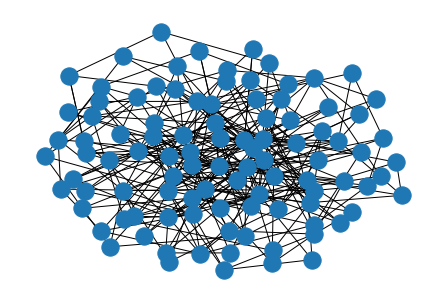

In [57]:
#Generemos un grafo de máxima entropía que tenga la distribución correspondiente a la probabilidada acumulada en el vector prob_cum
# es importante tener en cuenta que la discretización hecha a la distribución continua y el acote de su dominio no es único
grafo_maxent = maxent_generator(prob_cum,100,3)
#Gráfiquemos el grafo usando el algoritmo kamada kawai incorporado en networkx
nx.draw_kamada_kawai(grafo_maxent)

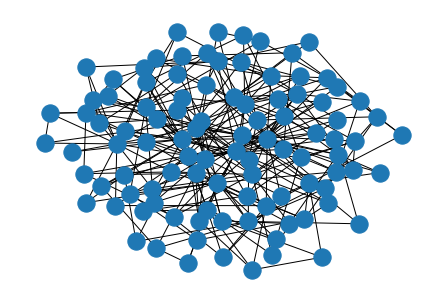

In [58]:
#Creemos un grafo con ley de potencias con el algoritmo de barabasi albert, estos suelen tener exponente entre -2 y -3
scale_free_graph = nx.barabasi_albert_graph(100,3)
#Grafiquemolo
nx.draw_kamada_kawai(scale_free_graph)

#¿Cual de los dos parece más centralizado? el grafo de máxima entropía intenta ser lo más representativo del ensamble de grafos con distribución de grado libre de escala, por está razón si el grafo de barabasi resulta más hub-centrico entonces este algoritmo no es un buen algoritmo para estudiar este ensamble.

# Para responder a esta pregunta estudiemos la robustez de las dos redes!

In [68]:
#copiemos lo grafos para no dañar los originales
maxent = grafo_maxent.copy()
barabasicopy = barabasi.copy()
#ahora apliquemosles estudiemos su robustez usando fallas en cascada causadas por ataques a los nodos hub-load de la red
maxent, ataques, daño = hub_cascade_failure(maxent,1.1,1.1,15)
barabasicopy, ataques2, daño2 = hub_cascade_failure(barabasicopy,1.1,1.1,15)

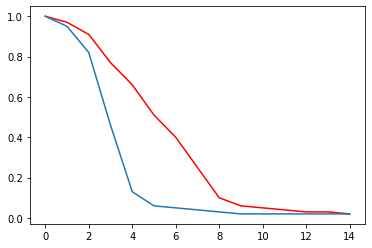

In [70]:
#ahora ploteemos sus daños y ataques
plt.plot(ataques,daño,color = "red")
plt.plot(ataques2,daño2)



#Acá evidenciamos que el grafo de máxima entropía resulta más robusto ante ataques a los hubs, lo cual muestra que es menos hub-centrico. Podría pensarse que está diferencia puede ser explicada por la diferencia de los exponentes de la ley de potencias, pero si se hace un estudio más refinado se encuentra que no es así



#Ahora evaluemos la robustez de estas redes ante distintos ataques!

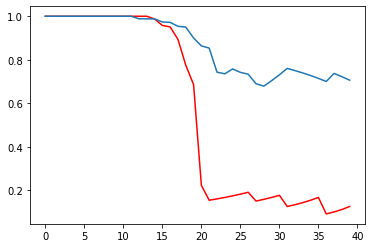

In [78]:
#copiemos lo grafos para no dañar los originales
maxent = grafo_maxent.copy()
barabasicopy = barabasi.copy()
#ahora apliquemosles estudiemos su robustez usando fallas en cascada causadas por ataques a los nodos hub-load de la red
maxent, ataques, daño = aleatory_cascade_failure(maxent,1.1,1.1,40)
barabasicopy, ataques2, daño2 = aleatory_cascade_failure(barabasicopy,1.1,1.1,40)

#ahora ploteemos sus daños y ataques
plt.plot(ataques,daño,color = "red")
plt.plot(ataques2,daño2)

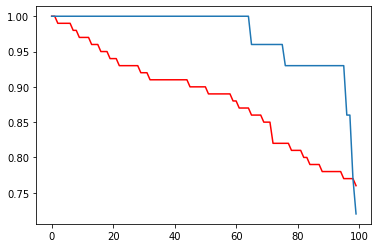

In [81]:
#copiemos lo grafos para no dañar los originales
maxent = grafo_maxent.copy()
barabasicopy = barabasi.copy()
#ahora apliquemosles estudiemos su robustez usando fallas en cascada causadas por ataques a los nodos hub-load de la red
maxent, ataques, daño = edge_hub_cascade_failure(maxent,1.1,1.1,100)
barabasicopy, ataques2, daño2 = edge_hub_cascade_failure(barabasicopy,1.1,1.1,100)

#ahora ploteemos sus daños y ataques
plt.plot(ataques,daño,color = "red")
plt.plot(ataques2,daño2)

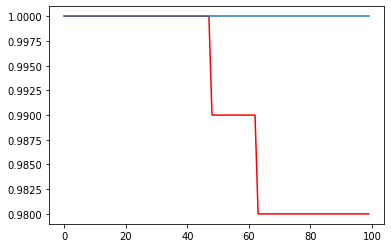

In [80]:
#copiemos lo grafos para no dañar los originales
maxent = grafo_maxent.copy()
barabasicopy = barabasi.copy()
#ahora apliquemosles estudiemos su robustez usando fallas en cascada causadas por ataques a los nodos hub-load de la red
maxent, ataques, daño = edge_aleatory_cascade_failure(maxent,1.1,1.1,100)
barabasicopy, ataques2, daño2 = edge_aleatory_cascade_failure(barabasicopy,1.1,1.1,100)

#ahora ploteemos sus daños y ataques
plt.plot(ataques,daño,color = "red")
plt.plot(ataques2,daño2)